In [1]:
# Python Version
from platform import python_version
print(python_version())

3.8.3


# Import and prepocessing of data

In [2]:
# Import necessary packages
import numpy as np
import pandas as pd

# Import Visualization Tools
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [3]:
# Import Dataset
df = pd.read_csv('churn_clean.csv')

# Drop unwanted variables/columns
drop_list =['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State',
            'County', 'Zip', 'Lat', 'Lng', 'Population', 'Area', 'TimeZone',
            'Job','Children', 'Age', 'Income', 'Marital', 'Gender','Item1', 
            'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8']

# Drop columns and save variables to list
df = df.drop(columns=drop_list)
used_variables = df.columns

# Convert "yes" and "no" to 1 and 0 respectively
df = df.replace(to_replace='Yes', value=1)
df = df.replace(to_replace='No',value=0)

# List and convert Categorical variables to dummy variables
to_dummy_list = ['Contract','InternetService', 'PaymentMethod']
df = pd.get_dummies(data=df, columns=to_dummy_list, drop_first=True)

# Save a copy of the prepared Dataset
df.to_csv('prepared_churn.csv', index=False)

# k-Nearest Neighbor Classification

In [4]:
# Import necessary modules for classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Assign target and response datasets
X = pd.DataFrame(StandardScaler().fit_transform(df.drop('Churn', axis=1)))
y = df['Churn']

# Set a Seed variable for analysis replication ability
SEED = 830

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Save datasets to CSVs for task prompt D2
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Instantiate the classifier
knn = KNeighborsClassifier(n_jobs=-1)

# Fit the classifier model
knn.fit(X_train, y_train)

# Calculate the predicted values for y
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

# Evaluate the accuracy of the model and print
acc = knn.score(X_test, y_test)
print('kNN model classification accuracy: {:.3f}'.format(acc))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1494
           1       0.72      0.68      0.70       506

    accuracy                           0.85      2000
   macro avg       0.80      0.79      0.80      2000
weighted avg       0.85      0.85      0.85      2000

kNN model classification accuracy: 0.851


## Tuning the models Hyperparameters

### Graph accuracy measure for different values of k

In [5]:
# The idea for this code was taken from the online 
#     learning resource videos on DataCamp

# Setup arrays to store train and test accuracies
neighbors = np.arange(20, 80, 5)
train_acc = np.empty(len(neighbors))
test_acc = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Instantiate a kNN model with k-neighbors
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

    # Fit the model to training data
    knn.fit(X=X_train, y=y_train)
    
    # Evaluate and store the training set accuracy
    train_acc[i] = knn.score(X_train, y_train)

    # Evaluate and store the testing set accuracy
    test_acc[i] = knn.score(X_test, y_test)

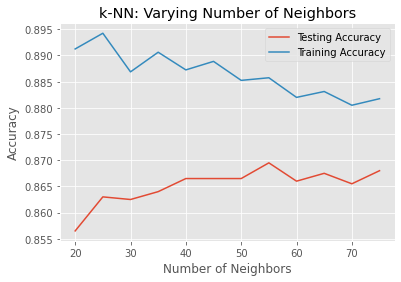

In [6]:
# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_acc, label = 'Testing Accuracy')
plt.plot(neighbors, train_acc, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Gridsearch to find optimal number of neighbors

In [7]:
from sklearn.model_selection import GridSearchCV

# Assign range of values to test for number of neighbors
n_neighbors= list(np.arange(50,61))

# Create the grid to use in the GridSearch
param_grid = {'n_neighbors':n_neighbors}

# Create the estimator to use
knn = KNeighborsClassifier(n_jobs=-1)

# Instantiate the GridSearch model
knn_cv = GridSearchCV(knn, param_grid, cv=5)

# Fit the model to the data
knn_cv.fit(X,y)

# Print the optimal number of neighbors to use
print(knn_cv.best_params_)

{'n_neighbors': 53}


## Testing a new model using 53 neighbors

In [8]:
# Instantiate the classifier
knn_2 = KNeighborsClassifier(n_neighbors=53,n_jobs=-1)

# Fit the classifier model
knn_2.fit(X_train, y_train)

# Calculate the predicted values for y
y_pred = knn_2.predict(X_test)
print(classification_report(y_test, y_pred))

# Evaluate the accuracy of the model and print
acc = knn_2.score(X_test, y_test)
print('kNN model classification accuracy: {:.3f}'.format(acc))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1494
           1       0.84      0.60      0.70       506

    accuracy                           0.87      2000
   macro avg       0.86      0.78      0.81      2000
weighted avg       0.87      0.87      0.86      2000

kNN model classification accuracy: 0.869


### Evaluating ROC Curve and AUC Score

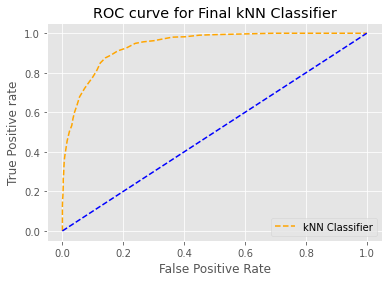

AUC Score of kNN Classifier = 0.780


In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

pred_prob = knn_2.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='kNN Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve for Final kNN Classifier')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend()
plt.show();


auc = roc_auc_score(y_test, y_pred)
print('AUC Score of kNN Classifier = {:.3f}'.format(auc))